In [ ]:
#importing necessary libraries

import pandas as pd
import numpy as np
from datetime import datetime

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

from prophet import Prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#DATASET ANALYSIS

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/DS5500/Meteorological_Data.csv")

In [ ]:
data.head(1)

,DATETIME,Avg BRBG Total Cloud Cover [%],Avg CDOC Total Cloud Cover [%],Avg CDOC Thick Cloud Cover [%],Avg CDOC Thin Cloud Cover [%],Avg Sun Flag,Avg HCF Value,Avg Blue/Red_min,Avg Blue/Red_mid,Avg Blue/Red_max,...,Avg Zenith Angle [degrees],Avg Azimuth Angle [degrees],Avg Solar Eclipse Shading,Avg Tower Dew Point Temp [deg C],Avg Total Cloud Cover [%],Avg Opaque Cloud Cover [%],Avg Avg Wind Speed @ 6ft [m/s],Avg Precipitation [mm],Avg Moisture,Avg Albedo (CMP11)
0,2021-10-08 07:00:00,13.6667,36.8333,0.0,36.8333,8.0,1.0367,0.9617,1.585,3.1533,...,85.6866,101.5014,0,-1.122,19.9667,10.4667,2.1028,0.0,0.0,0.2815


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8888 entries, 0 to 8887
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   DATETIME                             8888 non-null   object 
 1   Avg BRBG Total Cloud Cover [%]       8888 non-null   float64
 2   Avg CDOC Total Cloud Cover [%]       8888 non-null   float64
 3   Avg CDOC Thick Cloud Cover [%]       8888 non-null   float64
 4   Avg CDOC Thin Cloud Cover [%]        8888 non-null   float64
 5   Avg Sun Flag                         8888 non-null   float64
 6   Avg HCF Value                        8888 non-null   float64
 7   Avg Blue/Red_min                     8888 non-null   float64
 8   Avg Blue/Red_mid                     8888 non-null   float64
 9   Avg Blue/Red_max                     8888 non-null   float64
 10  Avg File Extension                   8888 non-null   float64
 11  Avg Global CMP22 (vent/cor) [W

#PREPROCESSING

In [ ]:
def preprocess_dataframe(df):
  """
  params:
  - df (dataframe): dataframe before preprocessing
  does:
  - Transform 'DATETIME' column from object to datetime format with renaming of column to timestamp.
  - Remove Outliers
  -Timestamp can be changed to index
  returns: Processed df (dataframe)
  """
  df['Timestamp'] = pd.to_datetime(df['DATETIME'])
  df.set_index('Timestamp', inplace=True) # set timestamp as index
  df=df.drop(['DATETIME', 'Avg Solar Eclipse Shading'], axis=1) # Remove null columns
  df = df[df["Avg CDOC Total Cloud Cover [%]"] !=-99999 ] # remove outliers
  return df

In [ ]:
df=preprocess_dataframe(data)

#FEATURE SELECTION

###Random Forest Regressor

In [ ]:
#Create X & Y
X = df.drop('Avg Global CMP22 (vent/cor) [W/m^2]', axis=1)
# Define the target variable
y = df['Avg Global CMP22 (vent/cor) [W/m^2]']

In [ ]:
# Create a Random Forest Regressor
Feature = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
#Train
Feature.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
# Get feature importances
feature_importances = Feature.feature_importances_
# Get the names of the features
feature_names = X.columns
# Sort the feature importances in descending order
sorted_idx = feature_importances.argsort()[::-1]
#Printing the Features
print("Feature ranking:")
for i in range(len(sorted_idx)):
    print(f"{i + 1}. Feature '{feature_names[sorted_idx[i]]}' ({feature_importances[sorted_idx[i]]})")

Feature ranking:
1. Feature 'Avg Zenith Angle [degrees]' (0.711676853954419)
2. Feature 'Avg Sun Flag' (0.19765764914799114)
3. Feature 'Avg Opaque Cloud Cover [%]' (0.026599596252951132)
4. Feature 'Avg Blue/Red_min' (0.023433460938002023)
5. Feature 'Avg BRBG Total Cloud Cover [%]' (0.007625086897657689)
6. Feature 'Avg Albedo (CMP11)' (0.005119917021154582)
7. Feature 'Avg Tower Dew Point Temp [deg C]' (0.0048628996228067736)
8. Feature 'Avg Total Cloud Cover [%]' (0.004115140587297173)
9. Feature 'Avg Azimuth Angle [degrees]' (0.003259371051480165)
10. Feature 'Avg Moisture' (0.0025836758806117186)
11. Feature 'Avg CDOC Total Cloud Cover [%]' (0.0023181755437306213)
12. Feature 'Avg Avg Wind Speed @ 6ft [m/s]' (0.0020149559570444638)
13. Feature 'Avg Blue/Red_mid' (0.002006201686007651)
14. Feature 'Avg Blue/Red_max' (0.0018984342275792418)
15. Feature 'Avg CDOC Thin Cloud Cover [%]' (0.0017791712973268753)
16. Feature 'Avg HCF Value' (0.001585757949694675)
17. Feature 'Avg CDOC Th

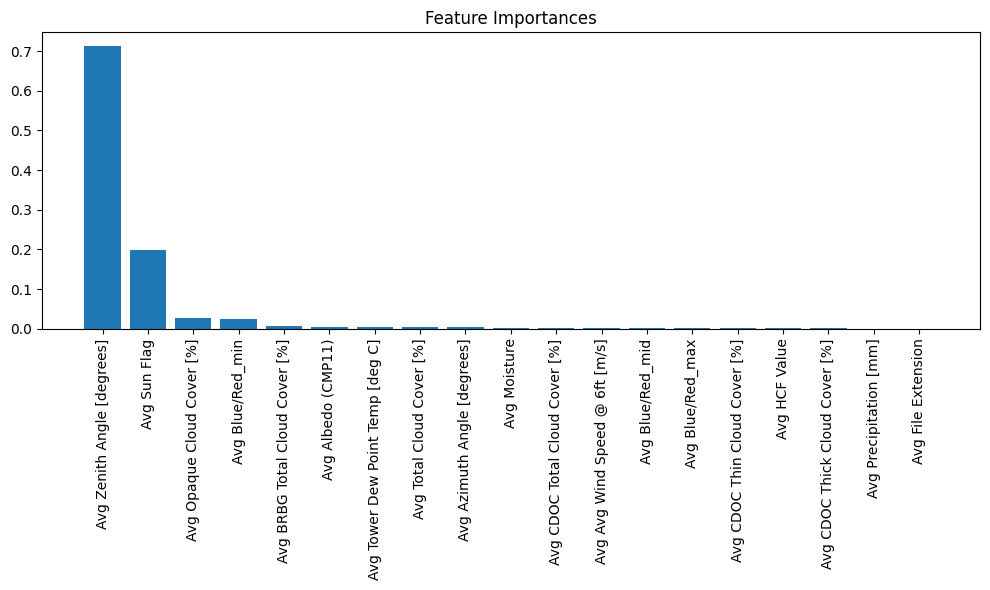

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.xticks(range(len(sorted_idx)), feature_names[sorted_idx], rotation=90)  # Added a closing parenthesis here
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
# !pip install -U kaleido

In [ ]:
#Univariate Feature Selection
k_best = SelectKBest(score_func=f_regression)
X_selected = k_best.fit_transform(X, y)
# Get the indices of the selected features
selected_feature_indices = k_best.get_support(indices=True)
# Get the names of the selected features
selected_feature_names = []
selected_feature_scores = []
columns = X.columns.tolist()
for i in selected_feature_indices:
  selected_feature_names.append(columns[i])
  selected_feature_scores.append(k_best.scores_[i])
  print(columns[i])
print(f"\nSelected {len(selected_feature_names)} features")
print("Scores: ", k_best.scores_)

Avg BRBG Total Cloud Cover [%]
Avg CDOC Total Cloud Cover [%]
Avg CDOC Thick Cloud Cover [%]
Avg CDOC Thin Cloud Cover [%]
Avg Sun Flag
Avg Blue/Red_min
Avg Zenith Angle [degrees]
Avg Opaque Cloud Cover [%]
Avg Avg Wind Speed @ 6ft [m/s]
Avg Moisture

Selected 10 features
Scores:  [3.00618081e+02 5.96140163e+02 1.93983842e+02 3.25013813e+02
 1.94870950e+03 7.33811835e+01 2.94285209e+03 1.10917423e+00
 1.09569640e+00 1.53475604e+00 1.75116585e+04 6.91767841e+01
 5.60178919e+01 1.60832915e+01 9.40903282e+01 2.51738997e+02
 2.66477128e+01 3.58770131e+02 1.40887147e+01]


In [ ]:
plot_scores = pd.DataFrame()
plot_scores["score"] = selected_feature_scores
plot_scores["name"]= selected_feature_names
plot_scores = plot_scores.sort_values(by='score', ascending=False)
fig = px.bar(y=plot_scores["score"], x=plot_scores["name"])
fig.show()

In [ ]:
# Forward Feature Selection
model = LinearRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select='auto', scoring='neg_mean_squared_error', cv=5)
sfs.fit(X, y)

selected_feature_indices = np.where(sfs.get_support())[0]

selected_feature_names = []
columns = X.columns.tolist()
for i in selected_feature_indices:
  selected_feature_names.append(columns[i])
  print(columns[i])

print(f"\nSelected {len(selected_feature_names)} features")

Avg BRBG Total Cloud Cover [%]
Avg CDOC Thin Cloud Cover [%]
Avg Blue/Red_min
Avg Zenith Angle [degrees]
Avg Tower Dew Point Temp [deg C]
Avg Total Cloud Cover [%]
Avg Opaque Cloud Cover [%]
Avg Moisture
Avg Albedo (CMP11)

Selected 9 features


# Selecting Features based on above and Modeling

In [ ]:
#Selecting certain columns and dropping the rest
#cols_to_keep = ['Avg Zenith Angle [degrees]','Avg Sun Flag','Avg Opaque Cloud Cover [%]','Avg Blue/Red_min','Avg Global CMP22 (vent/cor) [W/m^2]']
#data_df=X.loc[:, cols_to_keep]
#data_df=df.loc[:, cols_to_keep]

In [ ]:
cols_to_keep = ['Avg Zenith Angle [degrees]','Avg Sun Flag','Avg Opaque Cloud Cover [%]','Avg Blue/Red_min','Avg Global CMP22 (vent/cor) [W/m^2]','Avg BRBG Total Cloud Cover [%]','Avg Azimuth Angle [degrees]','Avg Albedo (CMP11)','Avg Tower Dew Point Temp [deg C]','Avg Total Cloud Cover [%]']
data_df=df.loc[:, cols_to_keep]

In [ ]:
data_df = data_df.reset_index()

In [ ]:
data_df = data_df.rename(columns={"Timestamp": "ds", "Avg Global CMP22 (vent/cor) [W/m^2]": "y"})

In [ ]:
#TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(data_df):
    train = data_df.iloc[train_index]
    valid = data_df.iloc[test_index]

In [ ]:
#initialize the model
model = Prophet(
    seasonality_mode='multiplicative',
    seasonality_prior_scale=0.1
)

In [ ]:
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/e1k54meo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/t0y44tp0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71956', 'data', 'file=/tmp/tmpv7jfpgpb/e1k54meo.json', 'init=/tmp/tmpv7jfpgpb/t0y44tp0.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modely0zt2i7f/prophet_model-20231030192433.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:24:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:24:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast = model.predict(valid)

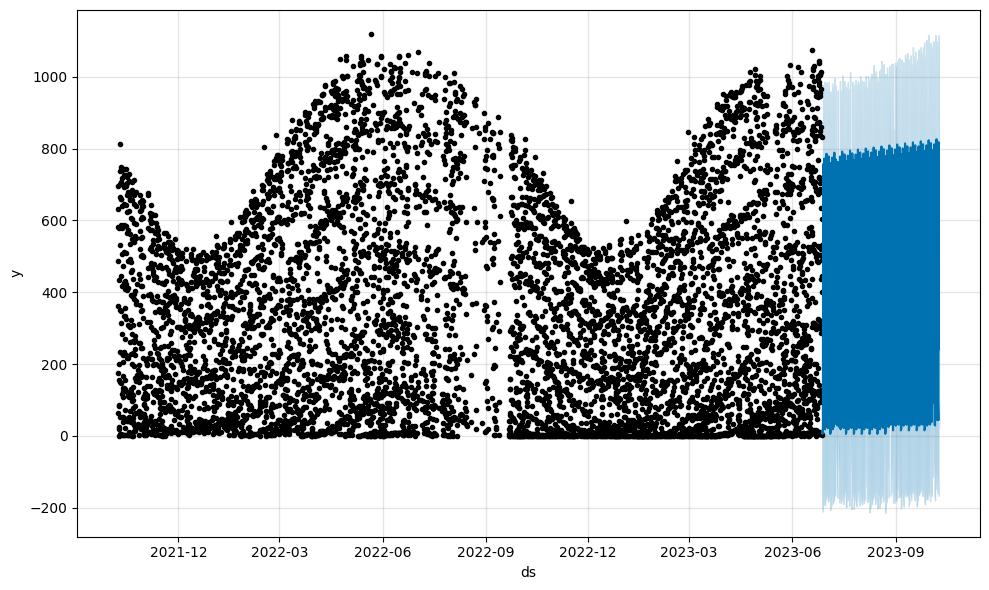

In [ ]:
fig = model.plot(forecast)

#EVALUATION

In [ ]:
forecasted_values = forecast[['ds', 'yhat']]

In [ ]:
forecasted_values.rename(columns={'ds': 'ds', 'yhat': 'forecasted_y'}, inplace=True)

<ipython-input-70-9280924d442f>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
merged_df = pd.merge(valid, forecasted_values, on='ds', how='inner')

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate evaluation metrics
y_true = merged_df['y']
y_pred = merged_df['forecasted_y']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 226.6331336745059
Mean Squared Error (MSE): 102256.06657451602
Root Mean Squared Error (RMSE): 319.7750249386528


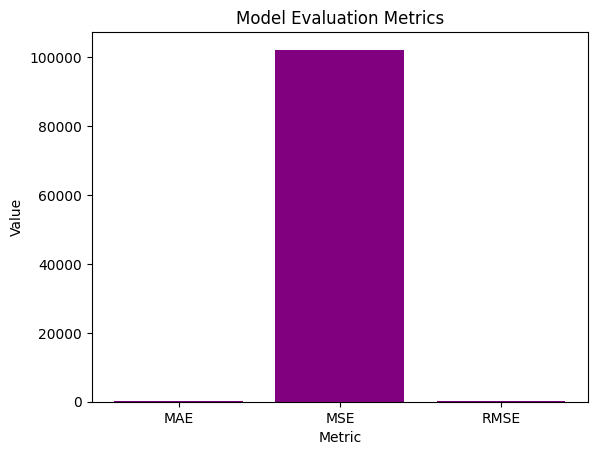

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot of evaluation metrics
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, rmse]

plt.bar(metrics, values, color='purple')
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

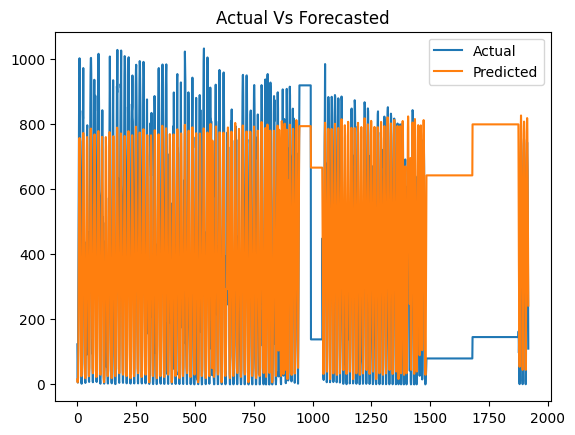

In [ ]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Actual Vs Forecasted")
plt.show()

#Modelling 2

In [ ]:
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

In [ ]:
m = Prophet(interval_width=0.95) #by default is 80%
model2 = m.fit(data_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/rr74czxl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/4xgsd9yd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98718', 'data', 'file=/tmp/tmpv7jfpgpb/rr74czxl.json', 'init=/tmp/tmpv7jfpgpb/4xgsd9yd.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model7mwi_ksi/prophet_model-20231030193508.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:35:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future12=m.make_future_dataframe(periods=90)

,ds
0,2021-10-08 07:00:00
1,2021-10-08 08:00:00
2,2021-10-08 09:00:00
3,2021-10-08 10:00:00
4,2021-10-08 11:00:00


In [ ]:
forecast12=m.predict(future12)

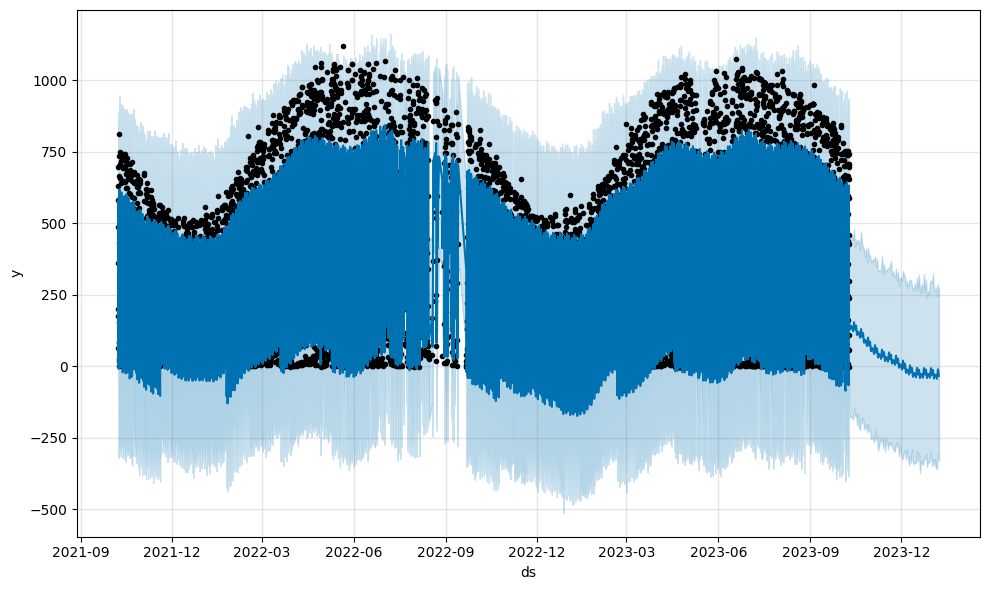

In [ ]:
plot1 = m.plot(forecast12)

Deep blue line is forecast sales forecast['y_hat'], black dots are actual sales forecast['y']. The light blue shade is 95% confidence interval around the forecast. The uncertainty interval in this region is bounded by forecast['yhat_lower'] and forecast['yhat_upper'] values.

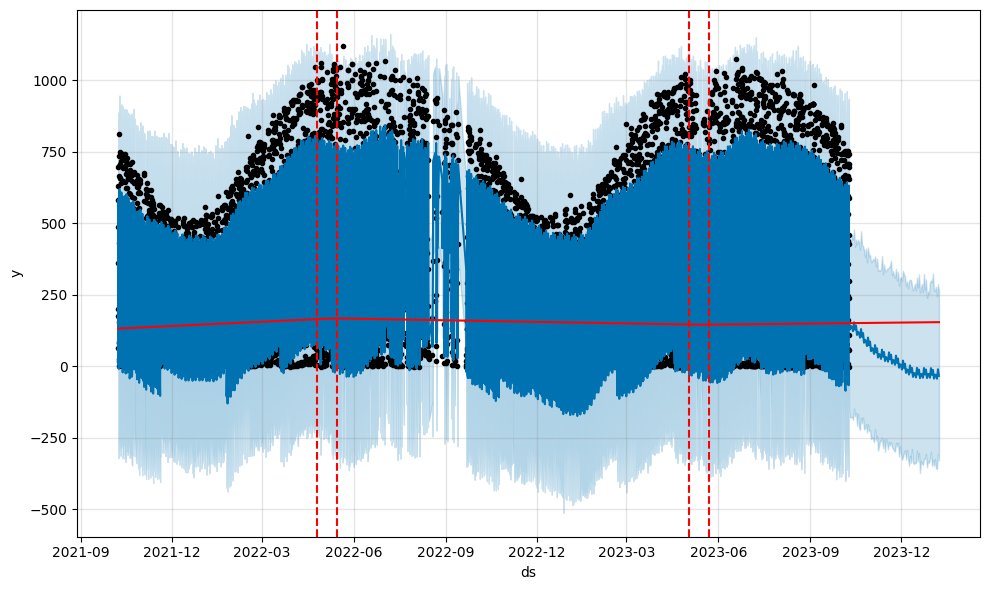

In [ ]:
from prophet.plot import add_changepoints_to_plot

plot1 = m.plot(forecast12)
a = add_changepoints_to_plot(plot1.gca(),m,forecast12)

#Component Plots

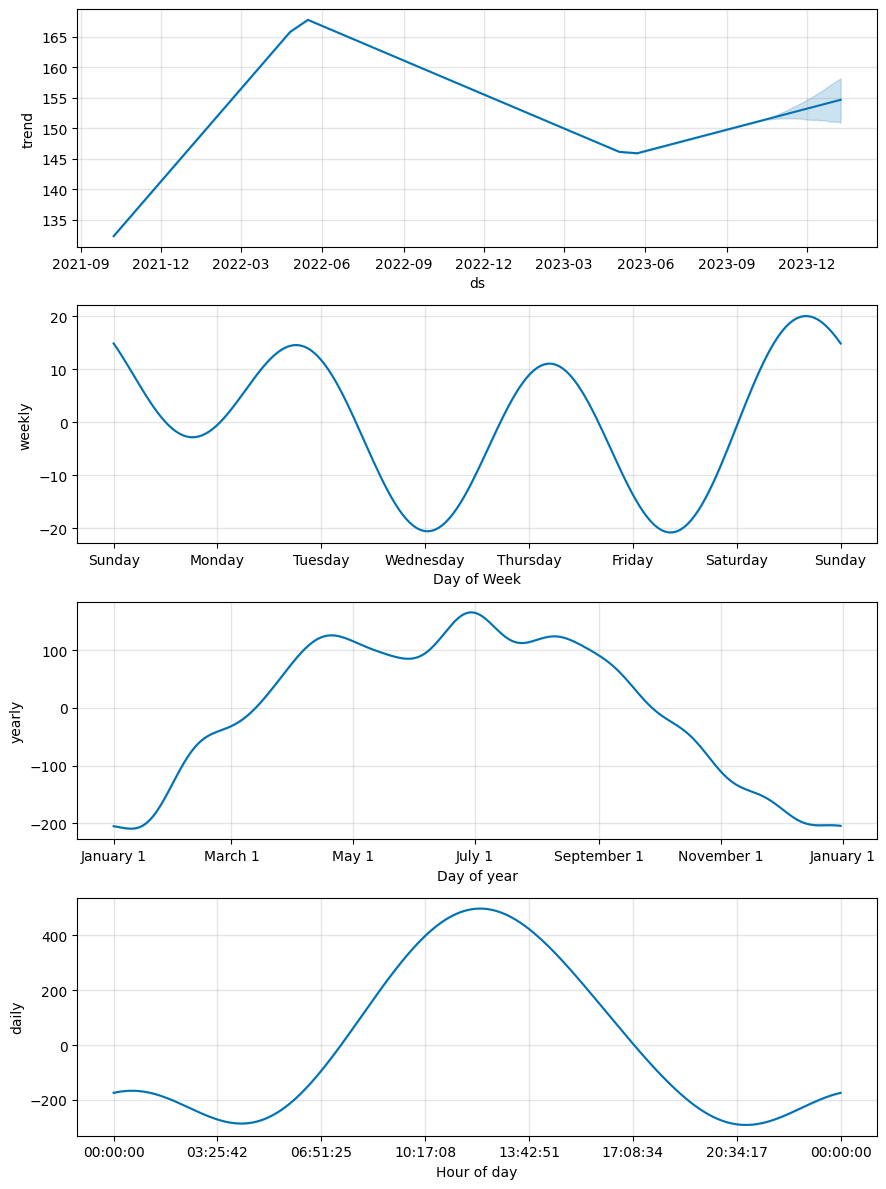

In [ ]:
plot2 = m.plot_components(forecast12)

#Evaluate model

In [ ]:
df_merge12 = pd.merge(data_df, forecast12[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge12 = df_merge12[['ds','yhat_lower','yhat_upper','yhat','y']]

,ds,yhat_lower,yhat_upper,yhat,y
0,2021-10-08 07:00:00,-300.234244,334.793299,11.879552,63.8407
1,2021-10-08 08:00:00,-163.928151,477.305997,161.761311,176.1522
2,2021-10-08 09:00:00,10.576276,643.612331,316.265671,361.7695
3,2021-10-08 10:00:00,146.816578,754.236618,451.434997,582.2481
4,2021-10-08 11:00:00,275.255798,853.375656,545.602838,632.4995


Mean Absolute Error (MAE): 115.59596573075612
Mean Squared Error (MSE): 24864.37985338616
Root Mean Squared Error (RMSE): 157.6844312333534


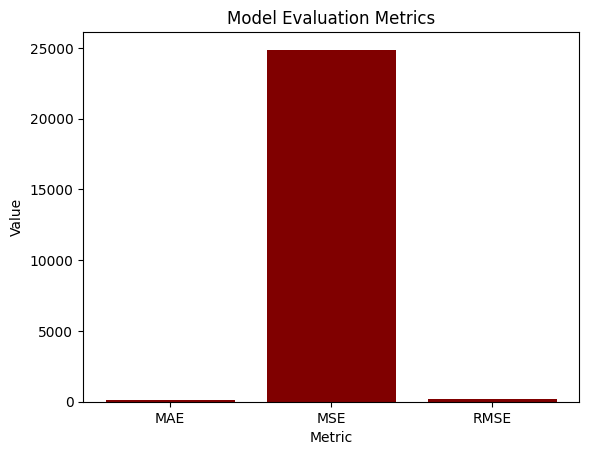

In [ ]:
# Calculate evaluation metrics

y_true = df_merge12['y'].values
y_pred = df_merge12['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

import matplotlib.pyplot as plt

# Create a bar plot of evaluation metrics
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, rmse]

plt.bar(metrics, values, color='maroon')
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

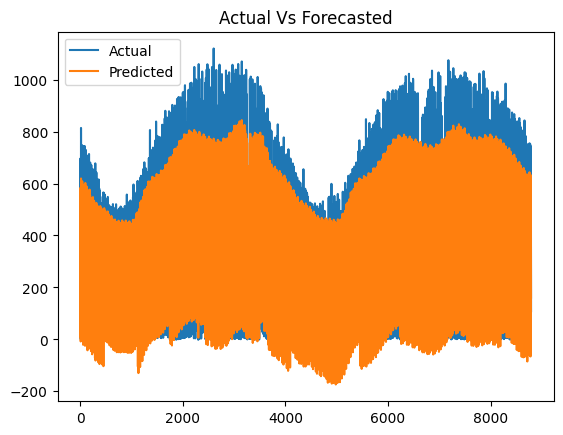

In [ ]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title("Actual Vs Forecasted")
plt.show()

#Cross Validation Without Hyperparameter Tuning

In [ ]:
m3 = Prophet(seasonality_mode='additive', seasonality_prior_scale='0.001').fit(data_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ils3_tzj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/7uwzn8ri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96200', 'data', 'file=/tmp/tmpv7jfpgpb/ils3_tzj.json', 'init=/tmp/tmpv7jfpgpb/7uwzn8ri.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3ef_gzpi/prophet_model-20231030203936.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:39:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:39:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
from prophet.diagnostics import cross_validation
df_cv_m3 = cross_validation(m3, initial='270 days', period='45 days', horizon = '90 days')

INFO:prophet:Making 9 forecasts with cutoffs between 2022-07-16 17:00:00 and 2023-07-11 17:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zztpb85u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3w1t1tyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5961', 'data', 'file=/tmp/tmpv7jfpgpb/zztpb85u.json', 'init=/tmp/tmpv7jfpgpb/3w1t1tyi.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_models7fpwjwh/prophet_model-20231030204004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:40:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:40:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3uhtedtm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/vx2tix9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

In [ ]:
from prophet.diagnostics import performance_metrics
df_p_m3 = performance_metrics(df_cv_m3)

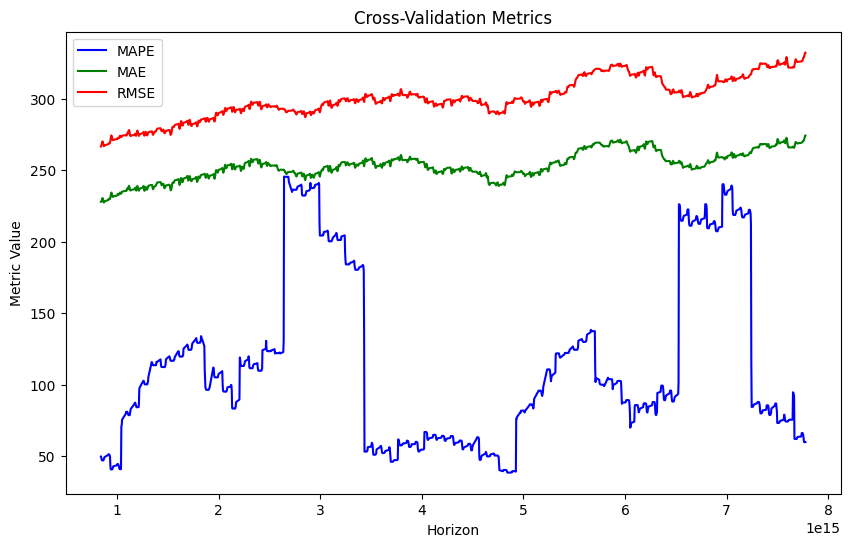

In [ ]:
# Plot multiple metrics in the same plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MAPE metric
performance_metrics_m3 = performance_metrics(df_cv_m3)
plt.plot(performance_metrics_m3['horizon'], performance_metrics_m3['mape'], label='MAPE', color='b')

# Plot the MAE metric
plt.plot(performance_metrics_m3['horizon'], performance_metrics_m3['mae'], label='MAE', color='g')

# Plot the RMSE metric
plt.plot(performance_metrics_m3['horizon'], performance_metrics_m3['rmse'], label='RMSE', color='r')

# Plot the MSE metric
#plt.plot(performance_metrics_m3['horizon'], performance_metrics_m3['mse'], label='MSE', color='cyan')

# Customize the plot as needed
plt.xlabel('Horizon')
plt.ylabel('Metric Value')
plt.title('Cross-Validation Metrics')
plt.legend()

plt.show()


# Hyperparameter Tuning

In [ ]:
# Python
import itertools

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
maes = []  # Store the MAE for each params here
mapes = [] # Store the MAPE for each params here
rmses=[]
mses=[]

# Use cross validation to evaluate all parameters
for params in all_params:
    m4 = Prophet(**params).fit(data_df)  # Fit model with given params
    df_cv = cross_validation(m4, horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    maes.append(df_p['mae'].values[0])
    mapes.append(df_p['mape'].values[0])
    rmses.append(df_p['rmse'].values[0])
    mses.append(df_p['mse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mae'] = maes
tuning_results['mape'] = mapes
tuning_results['rmse'] = rmses
tuning_results['mse'] = mses

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/45rqtkq9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/26c9fawa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24454', 'data', 'file=/tmp/tmpv7jfpgpb/45rqtkq9.json', 'init=/tmp/tmpv7jfpgpb/26c9fawa.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelx2xc4woy/prophet_model-20231030200937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:09:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:09:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 7 forecasts with cutoffs between 2022-10-14 17:00:00 and 2023-07-11 17:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7c4a22137f40>
DEBUG:cmdstanpy:input tempfile: 

In [ ]:
tuning_results_df = pd.DataFrame(tuning_results)

In [ ]:
tuning_results_df.sort_values(['rmse','mse','mae','mape'])

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,mae,mape,rmse,mse
6,0.010,0.10,additive,120.603086,18.854591,167.306427,27991.440671
10,0.100,0.10,additive,124.050074,20.047032,169.371421,28686.678106
7,0.010,0.10,multiplicative,125.311840,14.980993,170.752893,29156.550390
2,0.001,0.10,additive,122.718468,18.082579,171.519884,29419.070714
4,0.010,0.01,additive,132.861588,25.321778,173.455951,30086.966862
0,0.001,0.01,additive,136.447584,33.939641,177.215532,31405.344641
14,0.500,0.10,additive,130.427339,24.495538,180.295785,32506.569941
3,0.001,0.10,multiplicative,143.546915,23.991490,186.089097,34629.151904
11,0.100,0.10,multiplicative,132.124205,16.459438,189.615767,35954.139187
8,0.100,0.01,additive,156.766911,67.224380,204.611498,41865.864964


In [ ]:
best_params = all_params[np.argmin(mapes)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}


In [ ]:
best_params = all_params[np.argmin(rmse)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [ ]:
best_params = all_params[np.argmin(mse)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [ ]:
best_params = all_params[np.argmin(mae)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


#Model With Best Parameters

In [ ]:
m5 = Prophet(interval_width=0.95, weekly_seasonality=True,yearly_seasonality=True,
            changepoint_prior_scale=best_params['changepoint_prior_scale'],
            seasonality_prior_scale=best_params['seasonality_prior_scale'],
            seasonality_mode=best_params['seasonality_mode'])
model = m5.fit(data_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/6avzqp7m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/01nfwfct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1393', 'data', 'file=/tmp/tmpv7jfpgpb/6avzqp7m.json', 'init=/tmp/tmpv7jfpgpb/01nfwfct.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelr4wwx9ph/prophet_model-20231030202527.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:25:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:25:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m5.make_future_dataframe(periods=200)

In [ ]:
forecast = m5.predict(future)

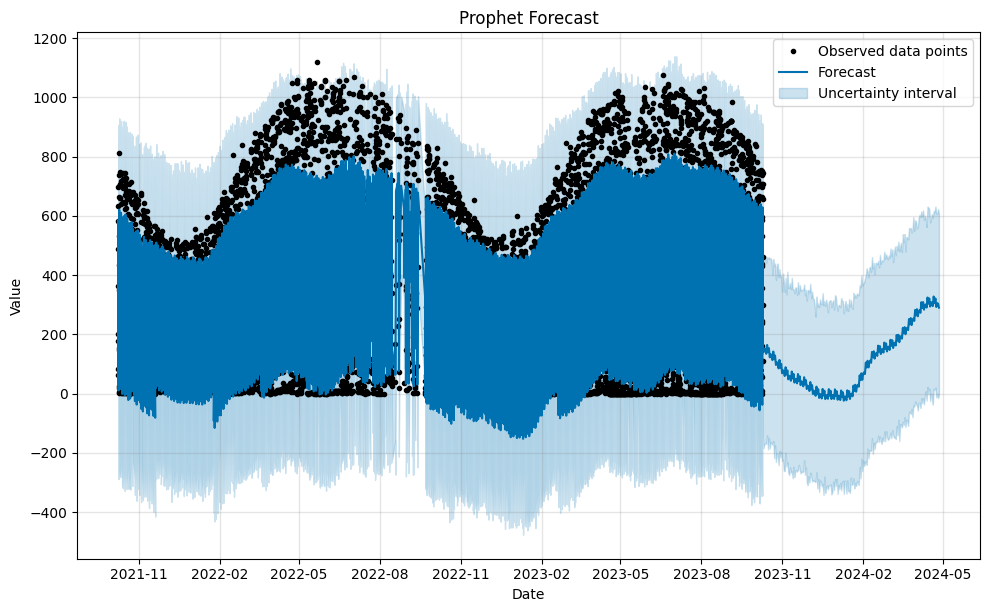

In [ ]:
# Create the Prophet forecast plot with custom colors
fig5 = m5.plot(forecast)

# Customize the plot as needed
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

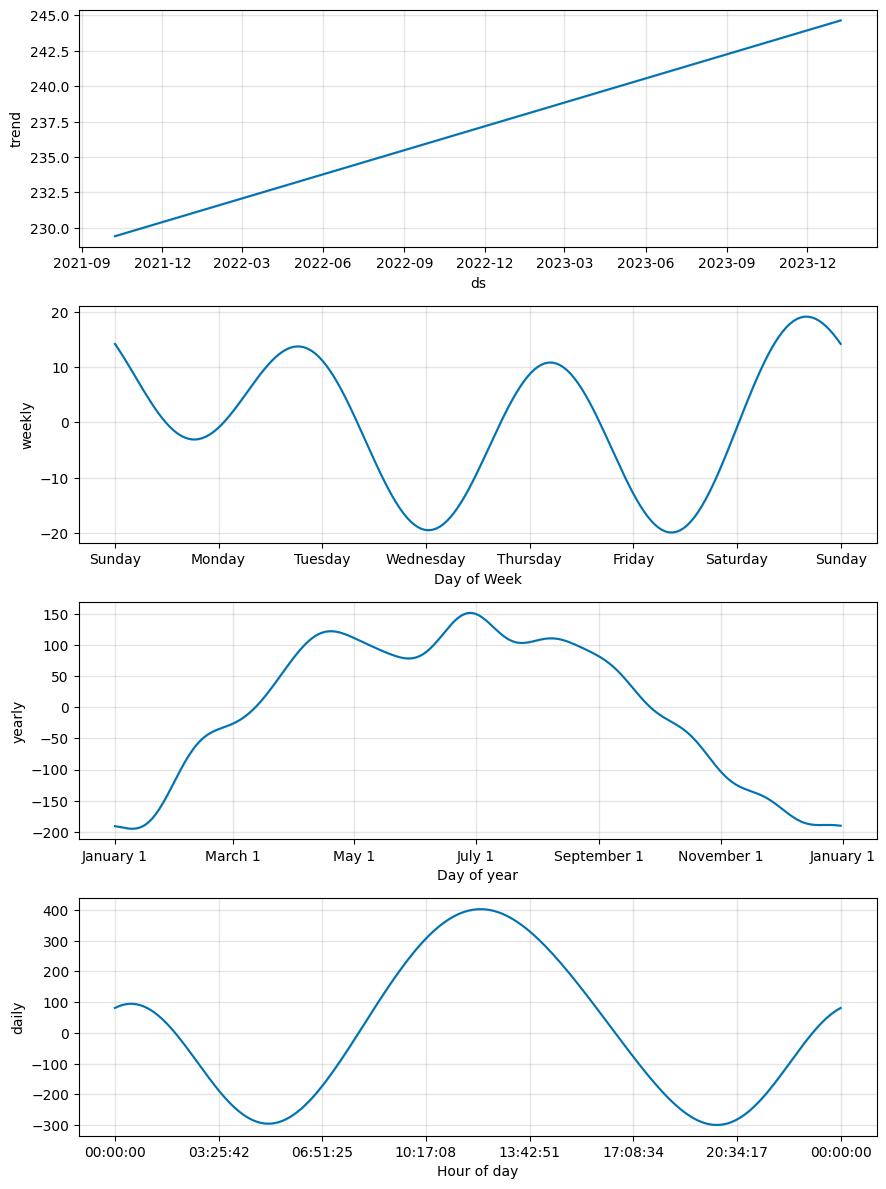

In [ ]:
plot6 = m5.plot_components(forecast)

In [ ]:
df_merge13 = pd.merge(data_df, forecast[['ds','yhat_lower','yhat_upper','yhat']],on='ds')
df_merge13 = df_merge13[['ds','yhat_lower','yhat_upper','yhat','y']]

Mean Absolute Error (MAE): 118.10670292828672
Mean Squared Error (MSE): 25200.680160356726
Root Mean Squared Error (RMSE): 158.74722095317676


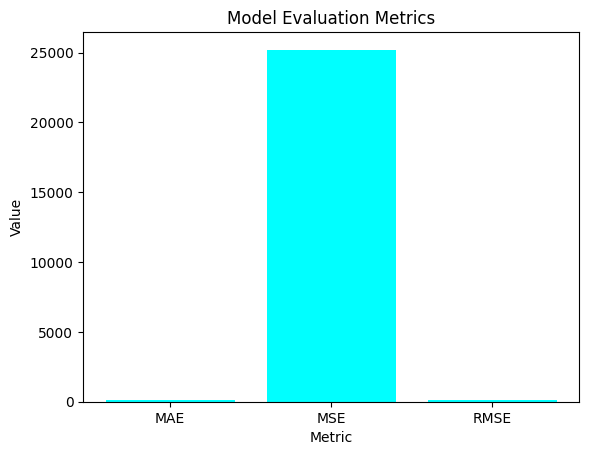

In [ ]:
# Calculate evaluation metrics

y_true = df_merge13['y'].values
y_pred = df_merge13['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

import matplotlib.pyplot as plt

# Create a bar plot of evaluation metrics
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, rmse]

plt.bar(metrics, values, color='cyan')
plt.title('Model Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')
plt.show()

#Rolling Window

If the process is constant over time, an expanding window forecast can provide a more stable and accurate estimate of the model’s parameters. However, if the underlying parameters of the model are changing over time, a rolling window forecast may be more appropriate as it places more emphasis on recent observations and provides estimates that are closer to the true parameters, but with more variance.

In [ ]:
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

In [228]:
best_rmse = float('inf')
best_mse = float('inf')
best_mae = float('inf')

In [229]:
# Set the timestamp column as the index
data_df.set_index('ds', inplace=True)

# Ensure that your data is sorted by timestamp
data_df.sort_index(inplace=True)

min_train_size =60  # Minimum training data points to start with

# Define lists to store evaluation metrics
all_rmses = []
all_mses = []
all_maes = []
all_forecasts = []  # Add this line to store forecasts

In [230]:
data_df = data_df.reset_index()

#DO NOT RUN

In [231]:
for i in range(min_train_size, len(data_df) + 1,61):
    train = data_df.iloc[:i]
    val = data_df.iloc[i:i + 1]

    print(i)

    # Loop through parameter combinations and evaluate performance
    model6 = Prophet(
            seasonality_prior_scale=best_params['seasonality_prior_scale'],
            seasonality_mode=best_params['seasonality_mode'])
    model6.fit(train)  # Use your training data

        # Make predictions on the validation set
        #future = model.make_future_dataframe(periods=len(df_validation))
    forecast = model6.predict(val)

        # Calculate RMSE on the validation set
    rmse = mean_squared_error(val['y'], forecast['yhat'], squared=False)
        # Calculate evaluation metrics (e.g., MSE or MAE)
    mse = mean_squared_error(val['y'], forecast['yhat'])
        #print(f"Mean Squared Error (MSE): {mse}")
    mae = mean_absolute_error(val['y'], forecast['yhat'])


    all_rmses.append(rmse)
    all_mses.append(mse)
    all_maes.append(mae)
    all_forecasts.append(forecast)

    # Check if this model has a lower RMSE
    if rmse < best_rmse or mse < best_mse or mae < best_mae:
            best_rmse = rmse
            best_mse = mse
            best_mae = mae
            best_model = model6

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/jewfdd84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/q2u7en8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34870', 'data', 'file=/tmp/tmpv7jfpgpb/jewfdd84.json', 'init=/tmp/tmpv7jfpgpb/q2u7en8q.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model1f8lqc7h/prophet_model-20231030224737.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


60
121


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/hz8mx0ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/eu70lt_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37692', 'data', 'file=/tmp/tmpv7jfpgpb/hz8mx0ne.json', 'init=/tmp/tmpv7jfpgpb/eu70lt_n.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model9wz7vcwm/prophet_model-20231030224737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonal

182
243


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/8jkmkxrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/mcnxxmut.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87472', 'data', 'file=/tmp/tmpv7jfpgpb/8jkmkxrn.json', 'init=/tmp/tmpv7jfpgpb/mcnxxmut.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modell3l0yuz5/prophet_model-20231030224738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

304
365


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ug1xkzek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3gm_k7c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53298', 'data', 'file=/tmp/tmpv7jfpgpb/ug1xkzek.json', 'init=/tmp/tmpv7jfpgpb/3gm_k7c3.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelukr9y2u3/prophet_model-20231030224738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

426
487


INFO:cmdstanpy:Chain [1] start processing
22:47:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/_ar3q0b7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/kwrwk9t7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85624', 'data', 'file=/tmp/tmpv7jfpgpb/_ar3q0b7.json', 'init=/tmp/tmpv7jfpgpb/kwrwk9t7.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelse8kvtxv/prophet_model-20231030224738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
I

548
609


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22858', 'data', 'file=/tmp/tmpv7jfpgpb/dkhom29o.json', 'init=/tmp/tmpv7jfpgpb/xivm65jr.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelhi72pn6v/prophet_model-20231030224739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/nfgijk3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3py3o7eb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-pack

670
731


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xa809450.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18718', 'data', 'file=/tmp/tmpv7jfpgpb/dutytj3_.json', 'init=/tmp/tmpv7jfpgpb/xa809450.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modela1oe1xb8/prophet_model-20231030224739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zrk3itom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/aspins3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBU

792
853


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/vfno542i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/wfkww4j2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94758', 'data', 'file=/tmp/tmpv7jfpgpb/vfno542i.json', 'init=/tmp/tmpv7jfpgpb/wfkww4j2.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model7brnrnt9/prophet_model-20231030224739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/qfgidues.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/908x9loq.json
DEBUG:cmdstanp

914
975


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/y3anzs7x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/pyyyptcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79264', 'data', 'file=/tmp/tmpv7jfpgpb/y3anzs7x.json', 'init=/tmp/tmpv7jfpgpb/pyyyptcx.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeluydqr455/prophet_model-20231030224740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

1036


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/31cbjlj9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/x951emyu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81952', 'data', 'file=/tmp/tmpv7jfpgpb/31cbjlj9.json', 'init=/tmp/tmpv7jfpgpb/x951emyu.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model1o8mobp5/prophet_model-20231030224740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1097


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/f52vg2gl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/jtpv1id6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64683', 'data', 'file=/tmp/tmpv7jfpgpb/f52vg2gl.json', 'init=/tmp/tmpv7jfpgpb/jtpv1id6.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeluzj8brqt/prophet_model-20231030224740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1158


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/k1rvtwx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/x43jhii6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71589', 'data', 'file=/tmp/tmpv7jfpgpb/k1rvtwx3.json', 'init=/tmp/tmpv7jfpgpb/x43jhii6.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelkhih0m0y/prophet_model-20231030224740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


1219


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ls5iei4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ctadnv5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72503', 'data', 'file=/tmp/tmpv7jfpgpb/ls5iei4q.json', 'init=/tmp/tmpv7jfpgpb/ctadnv5f.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model_9024iqh/prophet_model-20231030224741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1280


22:47:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3wkaudlw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/g0ns8cqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97333', 'data', 'file=/tmp/tmpv7jfpgpb/3wkaudlw.json', 'init=/tmp/tmpv7jfpgpb/g0ns8cqr.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelhr1ohh9f/prophet_model-20231030224741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1341


22:47:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/c6msnua8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/s9083148.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10021', 'data', 'file=/tmp/tmpv7jfpgpb/c6msnua8.json', 'init=/tmp/tmpv7jfpgpb/s9083148.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model9mtgnz2o/prophet_model-20231030224741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1402


22:47:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/0015p1fv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/90466zjv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8231', 'data', 'file=/tmp/tmpv7jfpgpb/0015p1fv.json', 'init=/tmp/tmpv7jfpgpb/90466zjv.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelqczhvxmj/prophet_model-20231030224742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1463


22:47:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/6zy38boc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/d39gixnb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90898', 'data', 'file=/tmp/tmpv7jfpgpb/6zy38boc.json', 'init=/tmp/tmpv7jfpgpb/d39gixnb.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelbmkvkwkr/prophet_model-20231030224742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1524


22:47:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/9lak2hxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xdhqgvp1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85405', 'data', 'file=/tmp/tmpv7jfpgpb/9lak2hxk.json', 'init=/tmp/tmpv7jfpgpb/xdhqgvp1.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model1rcmt2r7/prophet_model-20231030224743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1585


22:47:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/abbeh7eq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/poc1qkod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37244', 'data', 'file=/tmp/tmpv7jfpgpb/abbeh7eq.json', 'init=/tmp/tmpv7jfpgpb/poc1qkod.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3i8n065w/prophet_model-20231030224743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1646


22:47:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/y85e4dev.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/w0_qvus3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65392', 'data', 'file=/tmp/tmpv7jfpgpb/y85e4dev.json', 'init=/tmp/tmpv7jfpgpb/w0_qvus3.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelbhk37_s6/prophet_model-20231030224744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1707


22:47:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/gnghblz9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/gvh9crna.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86137', 'data', 'file=/tmp/tmpv7jfpgpb/gnghblz9.json', 'init=/tmp/tmpv7jfpgpb/gvh9crna.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model7hq3o5m6/prophet_model-20231030224744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1768


22:47:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/dsqh28p2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/adk9p7_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8181', 'data', 'file=/tmp/tmpv7jfpgpb/dsqh28p2.json', 'init=/tmp/tmpv7jfpgpb/adk9p7_4.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model2ouisyt7/prophet_model-20231030224745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1829


22:47:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/uk541ps2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/9uyjtxxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78864', 'data', 'file=/tmp/tmpv7jfpgpb/uk541ps2.json', 'init=/tmp/tmpv7jfpgpb/9uyjtxxb.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeld7x5_18l/prophet_model-20231030224745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1890


22:47:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/y7i3883k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/0rakv1fh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74168', 'data', 'file=/tmp/tmpv7jfpgpb/y7i3883k.json', 'init=/tmp/tmpv7jfpgpb/0rakv1fh.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelwhk3uq6h/prophet_model-20231030224746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


1951


22:47:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zjmbnlny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3vszv7mk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17', 'data', 'file=/tmp/tmpv7jfpgpb/zjmbnlny.json', 'init=/tmp/tmpv7jfpgpb/3vszv7mk.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelh9x73lhz/prophet_model-20231030224746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2012


22:47:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/u5rna0tg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/4vaso6v8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82939', 'data', 'file=/tmp/tmpv7jfpgpb/u5rna0tg.json', 'init=/tmp/tmpv7jfpgpb/4vaso6v8.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model6e66dvvg/prophet_model-20231030224746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2073


22:47:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/u22_9m_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/pj74octu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15865', 'data', 'file=/tmp/tmpv7jfpgpb/u22_9m_s.json', 'init=/tmp/tmpv7jfpgpb/pj74octu.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelf_h9equz/prophet_model-20231030224747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2134


22:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/vofmm6ny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/gx5izav8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4933', 'data', 'file=/tmp/tmpv7jfpgpb/vofmm6ny.json', 'init=/tmp/tmpv7jfpgpb/gx5izav8.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_models3bye93w/prophet_model-20231030224747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2195


22:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/o9n5g6_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ex1ya6iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57323', 'data', 'file=/tmp/tmpv7jfpgpb/o9n5g6_p.json', 'init=/tmp/tmpv7jfpgpb/ex1ya6iw.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelel6c0kia/prophet_model-20231030224747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2256


22:47:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zjhlfa39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/bhzu0jy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13493', 'data', 'file=/tmp/tmpv7jfpgpb/zjhlfa39.json', 'init=/tmp/tmpv7jfpgpb/bhzu0jy4.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeln9zw6506/prophet_model-20231030224748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2317


22:47:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/v1mi6iw1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ne96bgl2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34364', 'data', 'file=/tmp/tmpv7jfpgpb/v1mi6iw1.json', 'init=/tmp/tmpv7jfpgpb/ne96bgl2.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelp7e6oo2k/prophet_model-20231030224748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2378


22:47:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/jzmd1oeo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ajan43xn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87832', 'data', 'file=/tmp/tmpv7jfpgpb/jzmd1oeo.json', 'init=/tmp/tmpv7jfpgpb/ajan43xn.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3_h7yqf6/prophet_model-20231030224748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2439


22:47:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/tr4yurct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/u77aik6h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33162', 'data', 'file=/tmp/tmpv7jfpgpb/tr4yurct.json', 'init=/tmp/tmpv7jfpgpb/u77aik6h.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelb46a78f_/prophet_model-20231030224749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2500


22:47:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ha9tgz6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/k875v7di.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71892', 'data', 'file=/tmp/tmpv7jfpgpb/ha9tgz6m.json', 'init=/tmp/tmpv7jfpgpb/k875v7di.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3rvt2k1h/prophet_model-20231030224749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2561


22:47:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/965rw99e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/bap44sv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87586', 'data', 'file=/tmp/tmpv7jfpgpb/965rw99e.json', 'init=/tmp/tmpv7jfpgpb/bap44sv_.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelqbawt0n1/prophet_model-20231030224749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2622


22:47:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3bquft1l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/i053tro1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51812', 'data', 'file=/tmp/tmpv7jfpgpb/3bquft1l.json', 'init=/tmp/tmpv7jfpgpb/i053tro1.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model76k1yhbi/prophet_model-20231030224750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2683


22:47:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/yhck_166.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/32xbglng.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65464', 'data', 'file=/tmp/tmpv7jfpgpb/yhck_166.json', 'init=/tmp/tmpv7jfpgpb/32xbglng.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model8sgrghud/prophet_model-20231030224750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2744


22:47:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/8ere_bbw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/78vp99be.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82014', 'data', 'file=/tmp/tmpv7jfpgpb/8ere_bbw.json', 'init=/tmp/tmpv7jfpgpb/78vp99be.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelwol1wlpv/prophet_model-20231030224751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2805


22:47:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/uhgbil9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/sjdfbroo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9810', 'data', 'file=/tmp/tmpv7jfpgpb/uhgbil9_.json', 'init=/tmp/tmpv7jfpgpb/sjdfbroo.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3n619v15/prophet_model-20231030224751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2866


22:47:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/70m755io.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/kh421qsd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70841', 'data', 'file=/tmp/tmpv7jfpgpb/70m755io.json', 'init=/tmp/tmpv7jfpgpb/kh421qsd.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelrtai9c0_/prophet_model-20231030224752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2927


22:47:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/r0mutkb9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ps_6_toc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59050', 'data', 'file=/tmp/tmpv7jfpgpb/r0mutkb9.json', 'init=/tmp/tmpv7jfpgpb/ps_6_toc.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeli1wgx58s/prophet_model-20231030224752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


2988


22:47:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/m_gztsu1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/_1t6_f26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82458', 'data', 'file=/tmp/tmpv7jfpgpb/m_gztsu1.json', 'init=/tmp/tmpv7jfpgpb/_1t6_f26.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model5q_mf8d1/prophet_model-20231030224752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3049


22:47:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/yvfs3fqr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/a0ggrgmy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90252', 'data', 'file=/tmp/tmpv7jfpgpb/yvfs3fqr.json', 'init=/tmp/tmpv7jfpgpb/a0ggrgmy.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model_4ol8cq_/prophet_model-20231030224753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3110


22:47:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/o2mg6jyv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/dspa3ma1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97954', 'data', 'file=/tmp/tmpv7jfpgpb/o2mg6jyv.json', 'init=/tmp/tmpv7jfpgpb/dspa3ma1.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelafy338rx/prophet_model-20231030224753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3171


22:47:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/mmevyut9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/esc84qip.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37546', 'data', 'file=/tmp/tmpv7jfpgpb/mmevyut9.json', 'init=/tmp/tmpv7jfpgpb/esc84qip.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model7elwdks4/prophet_model-20231030224754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3232


22:47:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/34ps5anc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/dcvukwss.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83068', 'data', 'file=/tmp/tmpv7jfpgpb/34ps5anc.json', 'init=/tmp/tmpv7jfpgpb/dcvukwss.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelkgk0w37b/prophet_model-20231030224755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3293


22:47:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/gcir3jph.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xv4_8cdj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12793', 'data', 'file=/tmp/tmpv7jfpgpb/gcir3jph.json', 'init=/tmp/tmpv7jfpgpb/xv4_8cdj.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3o5fgzo7/prophet_model-20231030224755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3354


22:47:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/dz_zoniy.json


3415


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/k2ya38y2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73002', 'data', 'file=/tmp/tmpv7jfpgpb/dz_zoniy.json', 'init=/tmp/tmpv7jfpgpb/k2ya38y2.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model7no1zrjd/prophet_model-20231030224756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zsk2s3na.json


3476


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/g53voelb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64982', 'data', 'file=/tmp/tmpv7jfpgpb/zsk2s3na.json', 'init=/tmp/tmpv7jfpgpb/g53voelb.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelewo1rv5r/prophet_model-20231030224757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/uh57z7_g.json


3537


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/kd6xg6c5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36378', 'data', 'file=/tmp/tmpv7jfpgpb/uh57z7_g.json', 'init=/tmp/tmpv7jfpgpb/kd6xg6c5.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelcohqmxkl/prophet_model-20231030224758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


3598


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/6l4ryai8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/v5yznrwo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40315', 'data', 'file=/tmp/tmpv7jfpgpb/6l4ryai8.json', 'init=/tmp/tmpv7jfpgpb/v5yznrwo.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelg170_fgy/prophet_model-20231030224759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:47:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:47:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

3659


22:48:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/33j38108.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/x6w6uwxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88922', 'data', 'file=/tmp/tmpv7jfpgpb/33j38108.json', 'init=/tmp/tmpv7jfpgpb/x6w6uwxs.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeljdn81jvb/prophet_model-20231030224800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3720


22:48:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/jqtxpudr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/_sgslnkm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73515', 'data', 'file=/tmp/tmpv7jfpgpb/jqtxpudr.json', 'init=/tmp/tmpv7jfpgpb/_sgslnkm.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelt65w3a88/prophet_model-20231030224800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3781


22:48:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/eeot23ta.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/pohsck0h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81905', 'data', 'file=/tmp/tmpv7jfpgpb/eeot23ta.json', 'init=/tmp/tmpv7jfpgpb/pohsck0h.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelnrm_i_xt/prophet_model-20231030224801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3842


22:48:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/iex_ilzg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/17e25czf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16781', 'data', 'file=/tmp/tmpv7jfpgpb/iex_ilzg.json', 'init=/tmp/tmpv7jfpgpb/17e25czf.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelqc281d99/prophet_model-20231030224802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3903


22:48:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/r5r6niq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/aytl0pnt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50248', 'data', 'file=/tmp/tmpv7jfpgpb/r5r6niq2.json', 'init=/tmp/tmpv7jfpgpb/aytl0pnt.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelu84zroz9/prophet_model-20231030224802.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


3964


22:48:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/9ro7vo6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/hgjp40at.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41808', 'data', 'file=/tmp/tmpv7jfpgpb/9ro7vo6h.json', 'init=/tmp/tmpv7jfpgpb/hgjp40at.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeltssws3yj/prophet_model-20231030224803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


4025


22:48:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/lgzw5x_y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/qky7epbi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None


4086


DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45753', 'data', 'file=/tmp/tmpv7jfpgpb/lgzw5x_y.json', 'init=/tmp/tmpv7jfpgpb/qky7epbi.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelafc7i20z/prophet_model-20231030224803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ig9ivhqw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/wocddpwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43811', 'data

4147


22:48:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ei38ur4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/2vihrc6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93999', 'data', 'file=/tmp/tmpv7jfpgpb/ei38ur4y.json', 'init=/tmp/tmpv7jfpgpb/2vihrc6o.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelytdzqo4q/prophet_model-20231030224805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


4208


22:48:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ko6ffxo1.json


4269


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/_u8whz22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75135', 'data', 'file=/tmp/tmpv7jfpgpb/ko6ffxo1.json', 'init=/tmp/tmpv7jfpgpb/_u8whz22.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modela23d3_ec/prophet_model-20231030224805.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/tt5qv74d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/vqg207v_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBU

4330


22:48:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/9nhj5vo3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/alt478i1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92208', 'data', 'file=/tmp/tmpv7jfpgpb/9nhj5vo3.json', 'init=/tmp/tmpv7jfpgpb/alt478i1.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelhsinfov4/prophet_model-20231030224807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


4391


22:48:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/9v3gsq4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/oebe9508.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99210', 'data', 'file=/tmp/tmpv7jfpgpb/9v3gsq4q.json', 'init=/tmp/tmpv7jfpgpb/oebe9508.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelg6nizrhz/prophet_model-20231030224808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']


4452


22:48:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/_nfezngi.json


4513


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ssa81h4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10400', 'data', 'file=/tmp/tmpv7jfpgpb/_nfezngi.json', 'init=/tmp/tmpv7jfpgpb/ssa81h4o.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelw4lgfl28/prophet_model-20231030224809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ziol4yte.json


4574


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/huxza4kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35366', 'data', 'file=/tmp/tmpv7jfpgpb/ziol4yte.json', 'init=/tmp/tmpv7jfpgpb/huxza4kh.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelnu4powwb/prophet_model-20231030224810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/pd5he8qq.json


4635


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/n6p9t6t1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5060', 'data', 'file=/tmp/tmpv7jfpgpb/pd5he8qq.json', 'init=/tmp/tmpv7jfpgpb/n6p9t6t1.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelbcf1zs9o/prophet_model-20231030224811.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/sh9q003s.json


4696


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/92_027ay.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26024', 'data', 'file=/tmp/tmpv7jfpgpb/sh9q003s.json', 'init=/tmp/tmpv7jfpgpb/92_027ay.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelhdhzwzev/prophet_model-20231030224813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/p6c3yhha.json


4757


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/jn6ds6ve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95752', 'data', 'file=/tmp/tmpv7jfpgpb/p6c3yhha.json', 'init=/tmp/tmpv7jfpgpb/jn6ds6ve.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model2ostu0cc/prophet_model-20231030224814.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/cow0j7xs.json


4818


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/4s430q9e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99894', 'data', 'file=/tmp/tmpv7jfpgpb/cow0j7xs.json', 'init=/tmp/tmpv7jfpgpb/4s430q9e.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3utb17x4/prophet_model-20231030224815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3w7v6io_.json


4879


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/nuvb_8a1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12760', 'data', 'file=/tmp/tmpv7jfpgpb/3w7v6io_.json', 'init=/tmp/tmpv7jfpgpb/nuvb_8a1.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model4y9rit7i/prophet_model-20231030224816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/73bhwets.json


4940


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/lumvl0bj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45365', 'data', 'file=/tmp/tmpv7jfpgpb/73bhwets.json', 'init=/tmp/tmpv7jfpgpb/lumvl0bj.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelgf9wgj_w/prophet_model-20231030224817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/4w1h3ang.json


5001


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/9ftgu441.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65596', 'data', 'file=/tmp/tmpv7jfpgpb/4w1h3ang.json', 'init=/tmp/tmpv7jfpgpb/9ftgu441.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model_0c52obt/prophet_model-20231030224818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/he_7l4ak.json


5062


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/lmuvcfdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5245', 'data', 'file=/tmp/tmpv7jfpgpb/he_7l4ak.json', 'init=/tmp/tmpv7jfpgpb/lmuvcfdf.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelcol7nvs9/prophet_model-20231030224819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ew5f6nwp.json


5123


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/gwqy_icb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21780', 'data', 'file=/tmp/tmpv7jfpgpb/ew5f6nwp.json', 'init=/tmp/tmpv7jfpgpb/gwqy_icb.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeli7xie_eg/prophet_model-20231030224820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/m00kyvtp.json


5184


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/6r_rfz5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84017', 'data', 'file=/tmp/tmpv7jfpgpb/m00kyvtp.json', 'init=/tmp/tmpv7jfpgpb/6r_rfz5w.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model9uul844p/prophet_model-20231030224821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/o52h7ud6.json


5245


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/t8yr6shk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87720', 'data', 'file=/tmp/tmpv7jfpgpb/o52h7ud6.json', 'init=/tmp/tmpv7jfpgpb/t8yr6shk.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelac08w6zx/prophet_model-20231030224822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/_w6ubpiu.json


5306


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/at724k4q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52161', 'data', 'file=/tmp/tmpv7jfpgpb/_w6ubpiu.json', 'init=/tmp/tmpv7jfpgpb/at724k4q.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeli2m4152a/prophet_model-20231030224823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ge_v7gjg.json


5367


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/vw63y3j0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44423', 'data', 'file=/tmp/tmpv7jfpgpb/ge_v7gjg.json', 'init=/tmp/tmpv7jfpgpb/vw63y3j0.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modellmfk9hnf/prophet_model-20231030224823.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/n1hy0zei.json


5428


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/o50ssgcn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10884', 'data', 'file=/tmp/tmpv7jfpgpb/n1hy0zei.json', 'init=/tmp/tmpv7jfpgpb/o50ssgcn.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelhazqwccf/prophet_model-20231030224825.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/p27z0s2y.json


5489


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/4wbicj32.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29197', 'data', 'file=/tmp/tmpv7jfpgpb/p27z0s2y.json', 'init=/tmp/tmpv7jfpgpb/4wbicj32.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelmii8bwnn/prophet_model-20231030224826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/04wgrcuw.json


5550


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/7uuc1s4f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49898', 'data', 'file=/tmp/tmpv7jfpgpb/04wgrcuw.json', 'init=/tmp/tmpv7jfpgpb/7uuc1s4f.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3rwsurob/prophet_model-20231030224828.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xz3evaw8.json


5611


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/61cyarj8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53307', 'data', 'file=/tmp/tmpv7jfpgpb/xz3evaw8.json', 'init=/tmp/tmpv7jfpgpb/61cyarj8.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelt7nv07u5/prophet_model-20231030224829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/61fvinyw.json


5672


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xv4emima.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7711', 'data', 'file=/tmp/tmpv7jfpgpb/61fvinyw.json', 'init=/tmp/tmpv7jfpgpb/xv4emima.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model05mb89uj/prophet_model-20231030224830.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/43p009dt.json


5733


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/veb4mfoz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30443', 'data', 'file=/tmp/tmpv7jfpgpb/43p009dt.json', 'init=/tmp/tmpv7jfpgpb/veb4mfoz.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeln7zs8pyv/prophet_model-20231030224831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/imgd3ttq.json


5794


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/t9vcae9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66565', 'data', 'file=/tmp/tmpv7jfpgpb/imgd3ttq.json', 'init=/tmp/tmpv7jfpgpb/t9vcae9g.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelv3uzcf03/prophet_model-20231030224832.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


5855


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/d9v5t_y9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xhctzmw7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92112', 'data', 'file=/tmp/tmpv7jfpgpb/d9v5t_y9.json', 'init=/tmp/tmpv7jfpgpb/xhctzmw7.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model4c9yy40m/prophet_model-20231030224833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/yngff0ma.json


5916


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/w_loruvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69803', 'data', 'file=/tmp/tmpv7jfpgpb/yngff0ma.json', 'init=/tmp/tmpv7jfpgpb/w_loruvu.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelztrkd2vh/prophet_model-20231030224835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/hmhf9epg.json


5977


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/jg74pwao.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37320', 'data', 'file=/tmp/tmpv7jfpgpb/hmhf9epg.json', 'init=/tmp/tmpv7jfpgpb/jg74pwao.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelzalzi40c/prophet_model-20231030224836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/1neyi1sd.json


6038


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/c5oyghlf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57103', 'data', 'file=/tmp/tmpv7jfpgpb/1neyi1sd.json', 'init=/tmp/tmpv7jfpgpb/c5oyghlf.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelqul5tvdg/prophet_model-20231030224837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/34vzx62u.json


6099


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/no5xc5lt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32186', 'data', 'file=/tmp/tmpv7jfpgpb/34vzx62u.json', 'init=/tmp/tmpv7jfpgpb/no5xc5lt.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelqxatmptd/prophet_model-20231030224839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/oyxwfsk7.json


6160


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/wdxb2f83.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52550', 'data', 'file=/tmp/tmpv7jfpgpb/oyxwfsk7.json', 'init=/tmp/tmpv7jfpgpb/wdxb2f83.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelckrekuon/prophet_model-20231030224841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/lix0tqgc.json


6221


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ywdsv_x9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84376', 'data', 'file=/tmp/tmpv7jfpgpb/lix0tqgc.json', 'init=/tmp/tmpv7jfpgpb/ywdsv_x9.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelkic6mzh7/prophet_model-20231030224842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/d2diek3_.json


6282


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/cjx2ex5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60172', 'data', 'file=/tmp/tmpv7jfpgpb/d2diek3_.json', 'init=/tmp/tmpv7jfpgpb/cjx2ex5n.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelgye6f3rs/prophet_model-20231030224843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


6343


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/gzaxt_o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/522u85ti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85237', 'data', 'file=/tmp/tmpv7jfpgpb/gzaxt_o5.json', 'init=/tmp/tmpv7jfpgpb/522u85ti.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeltnwhop3v/prophet_model-20231030224845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/5ga1bksc.json


6404


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/rxk2c_2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22748', 'data', 'file=/tmp/tmpv7jfpgpb/5ga1bksc.json', 'init=/tmp/tmpv7jfpgpb/rxk2c_2n.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model9n7a4ipd/prophet_model-20231030224846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xxl08xrw.json


6465


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/w0_qed0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3886', 'data', 'file=/tmp/tmpv7jfpgpb/xxl08xrw.json', 'init=/tmp/tmpv7jfpgpb/w0_qed0t.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelhykgo1b4/prophet_model-20231030224848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/cuz_hldd.json


6526


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/fjmop6oh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85083', 'data', 'file=/tmp/tmpv7jfpgpb/cuz_hldd.json', 'init=/tmp/tmpv7jfpgpb/fjmop6oh.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeltu3nptbn/prophet_model-20231030224849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/a3a6x_fk.json


6587


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/90w1n4jh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74841', 'data', 'file=/tmp/tmpv7jfpgpb/a3a6x_fk.json', 'init=/tmp/tmpv7jfpgpb/90w1n4jh.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelfidhfdnb/prophet_model-20231030224851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/x9qg3n2u.json


6648


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/669aj62f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62034', 'data', 'file=/tmp/tmpv7jfpgpb/x9qg3n2u.json', 'init=/tmp/tmpv7jfpgpb/669aj62f.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeldc9vy7qe/prophet_model-20231030224853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/s4yf31u_.json


6709


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/1rye_umm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19727', 'data', 'file=/tmp/tmpv7jfpgpb/s4yf31u_.json', 'init=/tmp/tmpv7jfpgpb/1rye_umm.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelcq49fdul/prophet_model-20231030224856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:48:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ii627b0t.json


6770


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/7r4ksu16.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88697', 'data', 'file=/tmp/tmpv7jfpgpb/ii627b0t.json', 'init=/tmp/tmpv7jfpgpb/7r4ksu16.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelzmcdvd_s/prophet_model-20231030224858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:48:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/hvv7vlhv.json


6831


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/i83k2zpm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4458', 'data', 'file=/tmp/tmpv7jfpgpb/hvv7vlhv.json', 'init=/tmp/tmpv7jfpgpb/i83k2zpm.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model_syz94wa/prophet_model-20231030224900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/bd8ncj04.json


6892


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/cc29tcq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33237', 'data', 'file=/tmp/tmpv7jfpgpb/bd8ncj04.json', 'init=/tmp/tmpv7jfpgpb/cc29tcq4.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelnbh5v5a5/prophet_model-20231030224902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/rqic9efs.json


6953


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/dbs3239k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3160', 'data', 'file=/tmp/tmpv7jfpgpb/rqic9efs.json', 'init=/tmp/tmpv7jfpgpb/dbs3239k.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelvbdkao4k/prophet_model-20231030224904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/7htqfsoy.json


7014


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/70khcffg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48775', 'data', 'file=/tmp/tmpv7jfpgpb/7htqfsoy.json', 'init=/tmp/tmpv7jfpgpb/70khcffg.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model9tli2qxu/prophet_model-20231030224906.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/kromh7_6.json


7075


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/orb3rjtp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86986', 'data', 'file=/tmp/tmpv7jfpgpb/kromh7_6.json', 'init=/tmp/tmpv7jfpgpb/orb3rjtp.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modela_xxblr0/prophet_model-20231030224907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/whd6bm1_.json


7136


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/rr5lan6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30780', 'data', 'file=/tmp/tmpv7jfpgpb/whd6bm1_.json', 'init=/tmp/tmpv7jfpgpb/rr5lan6e.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelg_jhbp3e/prophet_model-20231030224909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


7197


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zfdfti2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zdkqxt26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64975', 'data', 'file=/tmp/tmpv7jfpgpb/zfdfti2g.json', 'init=/tmp/tmpv7jfpgpb/zdkqxt26.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelspr9ch31/prophet_model-20231030224911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

7258


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/2kqm0tlq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98047', 'data', 'file=/tmp/tmpv7jfpgpb/xn59a1am.json', 'init=/tmp/tmpv7jfpgpb/2kqm0tlq.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelpjmgh60m/prophet_model-20231030224913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/apc6c18e.json


7319


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/patm3j3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63543', 'data', 'file=/tmp/tmpv7jfpgpb/apc6c18e.json', 'init=/tmp/tmpv7jfpgpb/patm3j3x.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model1hg7fujh/prophet_model-20231030224915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/kankeukx.json


7380


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ys0482la.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65059', 'data', 'file=/tmp/tmpv7jfpgpb/kankeukx.json', 'init=/tmp/tmpv7jfpgpb/ys0482la.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model3ccw7stl/prophet_model-20231030224916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/vs2b1fyj.json


7441


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zz5np97u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36645', 'data', 'file=/tmp/tmpv7jfpgpb/vs2b1fyj.json', 'init=/tmp/tmpv7jfpgpb/zz5np97u.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model8e7u87yb/prophet_model-20231030224918.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/qgymvo4c.json


7502


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/cqvey2xw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76248', 'data', 'file=/tmp/tmpv7jfpgpb/qgymvo4c.json', 'init=/tmp/tmpv7jfpgpb/cqvey2xw.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeltfmb5t1y/prophet_model-20231030224919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


7563


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/l1c2j491.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/2w688s7g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59545', 'data', 'file=/tmp/tmpv7jfpgpb/l1c2j491.json', 'init=/tmp/tmpv7jfpgpb/2w688s7g.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model99i_l3s6/prophet_model-20231030224921.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

7624


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zb_njbw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96318', 'data', 'file=/tmp/tmpv7jfpgpb/e3sfv55d.json', 'init=/tmp/tmpv7jfpgpb/zb_njbw8.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model_mdoliol/prophet_model-20231030224923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zlhdtwab.json


7685


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xsumx8cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53784', 'data', 'file=/tmp/tmpv7jfpgpb/zlhdtwab.json', 'init=/tmp/tmpv7jfpgpb/xsumx8cg.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelz6_2uk6k/prophet_model-20231030224925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/w9hq7sux.json


7746


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/eh08_tpj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32177', 'data', 'file=/tmp/tmpv7jfpgpb/w9hq7sux.json', 'init=/tmp/tmpv7jfpgpb/eh08_tpj.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model73zr76t_/prophet_model-20231030224927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/557q0q_y.json


7807


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/v06xj7na.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99365', 'data', 'file=/tmp/tmpv7jfpgpb/557q0q_y.json', 'init=/tmp/tmpv7jfpgpb/v06xj7na.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelzomwmgkn/prophet_model-20231030224928.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


7868


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/c6cezlsk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/phg2yp7u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63395', 'data', 'file=/tmp/tmpv7jfpgpb/c6cezlsk.json', 'init=/tmp/tmpv7jfpgpb/phg2yp7u.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modele45jjxkd/prophet_model-20231030224931.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ds1zpc3s.json


7929


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/7jlwm2y9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77899', 'data', 'file=/tmp/tmpv7jfpgpb/ds1zpc3s.json', 'init=/tmp/tmpv7jfpgpb/7jlwm2y9.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model31xskjrc/prophet_model-20231030224933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/3ef468h9.json


7990


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/1zad9eyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2772', 'data', 'file=/tmp/tmpv7jfpgpb/3ef468h9.json', 'init=/tmp/tmpv7jfpgpb/1zad9eyp.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model7uyyveen/prophet_model-20231030224934.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/7l7o69lb.json


8051


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/ugxsz9m2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78174', 'data', 'file=/tmp/tmpv7jfpgpb/7l7o69lb.json', 'init=/tmp/tmpv7jfpgpb/ugxsz9m2.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelmogll51b/prophet_model-20231030224937.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/lzclnj6i.json


8112


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/m4evd0e0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92727', 'data', 'file=/tmp/tmpv7jfpgpb/lzclnj6i.json', 'init=/tmp/tmpv7jfpgpb/m4evd0e0.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelk5t8i18q/prophet_model-20231030224939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/_xm22z7v.json


8173


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/8sv_0hro.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79756', 'data', 'file=/tmp/tmpv7jfpgpb/_xm22z7v.json', 'init=/tmp/tmpv7jfpgpb/8sv_0hro.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeldbyulqgq/prophet_model-20231030224941.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/sl7lykzb.json


8234


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/wqtytglk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77084', 'data', 'file=/tmp/tmpv7jfpgpb/sl7lykzb.json', 'init=/tmp/tmpv7jfpgpb/wqtytglk.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model4rnm4ild/prophet_model-20231030224943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/cjfk4jq3.json


8295


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/xy_r8frd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19714', 'data', 'file=/tmp/tmpv7jfpgpb/cjfk4jq3.json', 'init=/tmp/tmpv7jfpgpb/xy_r8frd.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelca2e__1y/prophet_model-20231030224945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/zrvmczxa.json


8356


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/x89v_14g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41993', 'data', 'file=/tmp/tmpv7jfpgpb/zrvmczxa.json', 'init=/tmp/tmpv7jfpgpb/x89v_14g.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model9vziz3zd/prophet_model-20231030224946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/vqn3xnhc.json


8417


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/gvl93eb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69269', 'data', 'file=/tmp/tmpv7jfpgpb/vqn3xnhc.json', 'init=/tmp/tmpv7jfpgpb/gvl93eb2.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model4fslze1l/prophet_model-20231030224949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/l5vozalg.json


8478


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/tp_c9j4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2867', 'data', 'file=/tmp/tmpv7jfpgpb/l5vozalg.json', 'init=/tmp/tmpv7jfpgpb/tp_c9j4e.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelcnadc3k0/prophet_model-20231030224952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/lyt0wres.json


8539


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/7lbf6_5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73156', 'data', 'file=/tmp/tmpv7jfpgpb/lyt0wres.json', 'init=/tmp/tmpv7jfpgpb/7lbf6_5b.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_model9dn89h42/prophet_model-20231030224954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/domwq51v.json


8600


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/jo6i2bq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19315', 'data', 'file=/tmp/tmpv7jfpgpb/domwq51v.json', 'init=/tmp/tmpv7jfpgpb/jo6i2bq5.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelg49br51e/prophet_model-20231030224956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:49:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/smgm8nd8.json


8661


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/fuw19mpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2449', 'data', 'file=/tmp/tmpv7jfpgpb/smgm8nd8.json', 'init=/tmp/tmpv7jfpgpb/fuw19mpp.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modeltt338aa7/prophet_model-20231030224958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:49:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/x2bor_2w.json


8722


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/lkbg0sgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31081', 'data', 'file=/tmp/tmpv7jfpgpb/x2bor_2w.json', 'init=/tmp/tmpv7jfpgpb/lkbg0sgd.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modely25p89r_/prophet_model-20231030225000.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/m_mq7rn7.json


8783


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv7jfpgpb/kattjvgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33035', 'data', 'file=/tmp/tmpv7jfpgpb/m_mq7rn7.json', 'init=/tmp/tmpv7jfpgpb/kattjvgt.json', 'output', 'file=/tmp/tmpv7jfpgpb/prophet_modelo9d7l13l/prophet_model-20231030225002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:50:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:50:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [234]:
# After the loop, you can calculate additional evaluation metrics if needed
print(f"Best RMSE: {best_rmse}")
print(f"Best MSE: {best_mse}")
print(f"Best MAE: {min(all_maes)}")
print(f"Best Model Parameters: {best_model}")

Best RMSE: 0.4956843144981917
Best MSE: 0.24570293963954223
Best MAE: 0.4956843144981917
Best Model Parameters: <prophet.forecaster.Prophet object at 0x7c4a0b8ef070>


In [ ]:
print("Best Model Parameters:")
print(f"Seasonality Mode: {best_model.seasonality_mode}")
print(f"Seasonality Prior Scale: {best_model.seasonality_prior_scale}")

Best Model Parameters:
Seasonality Mode: additive
Seasonality Prior Scale: 0.1


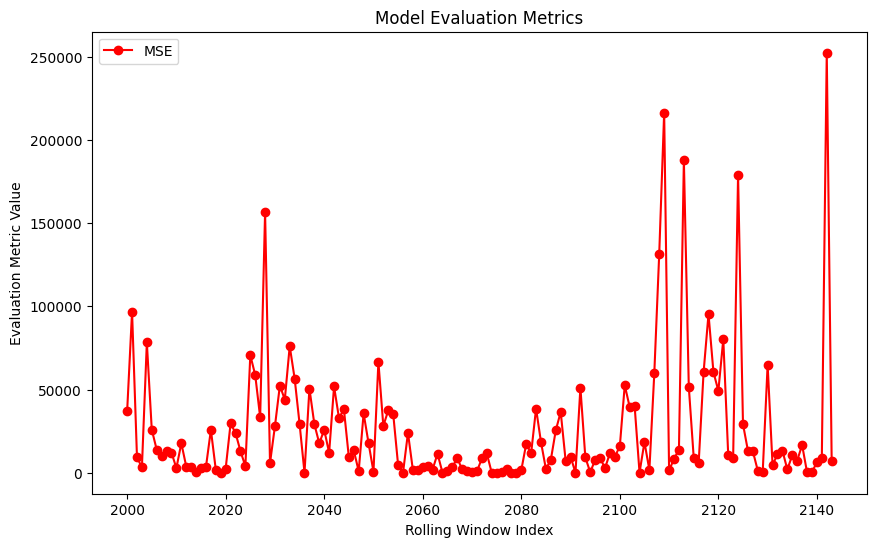

In [ ]:
start_index = 2000
end_index = start_index + len(all_mses)

# Create the x values for the plot
x_values = range(start_index, end_index)

# Plot RMSE and MSE
plt.figure(figsize=(10, 6))
#plt.plot(x_values,all_rmses, label='RMSE', marker='o')
plt.plot(x_values,all_mses, label='MSE', marker='o', color='r')
plt.xlabel('Rolling Window Index')
plt.ylabel('Evaluation Metric Value')
plt.legend()
plt.title('Model Evaluation Metrics')
plt.show()

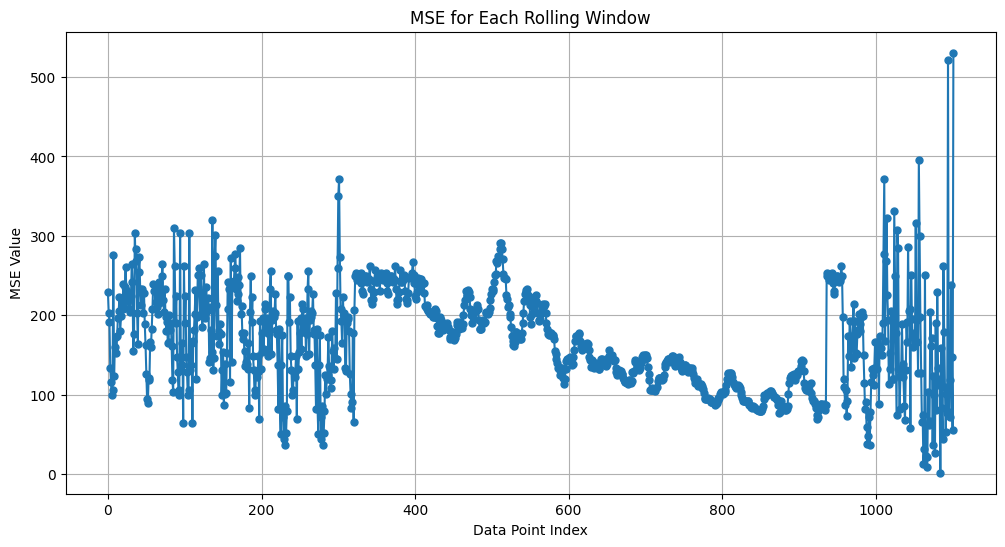

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace this with your actual data)
x_values = range(0,len(all_mses))  # Adjust the range as needed
rmse_values = all_rmses  # Replace 'all_mses' with your actual MSE data


# Plot the repeated data
plt.figure(figsize=(12, 6))
plt.plot(x_values, rmse_values, marker='o', linestyle='-', markersize=5)
plt.title('MSE for Each Rolling Window')
plt.xlabel('Data Point Index')
plt.ylabel('MSE Value')
plt.grid(True)
plt.show()


<ipython-input-227-e50f05a47dc9>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-227-e50f05a47dc9>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-227-e50f05a47dc9>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-227-e50f05a47dc9>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-227-e50f05a47dc9>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-227-e50f05a47dc9>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Us

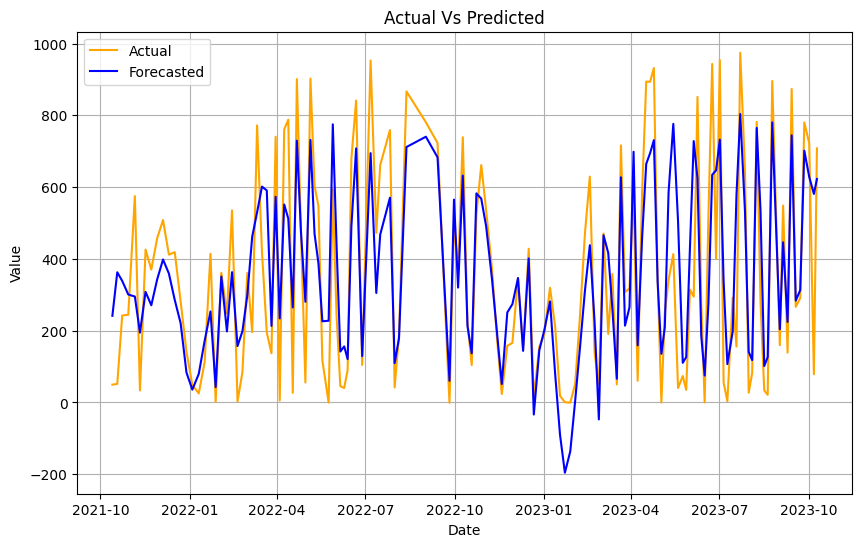

In [227]:
import matplotlib.pyplot as plt
import pandas as pd

# Create an empty DataFrame to combine all forecasts
combined_forecast = pd.DataFrame()

# Iterate through the list of forecasts and combine them
for forecast in all_forecasts:
    combined_forecast = combined_forecast.append(forecast)

# Merge data_df and combined_forecast on 'ds' column
merged_data6 = data_df.merge(combined_forecast, on='ds', how='inner')

# Create a plot of yhat and y against ds
plt.figure(figsize=(10, 6))
plt.plot(merged_data6['ds'], merged_data6['y'], label='Actual', color='orange')
plt.plot(merged_data6['ds'], merged_data6['yhat'], label='Forecasted', color='b')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Vs Predicted')
plt.legend()
plt.grid(True)
plt.show()
